## Investigating_Data_Science_Stack_Exchange

[Stack Exchange](https://stackexchange.com/sites) hosts sites on a multitude of fields and subjects, including mathematics, physics, philosophy, and data science! It employs a reputation award system for its questions and answers. Each post - each question/answer - is a post that is subject to upvotes and downvotes. This ensures that good posts are easily identifiable.

Our goal in this project is to use [Data Science Stack Exchange](https://datascience.stackexchange.com/) to determine what content should a data science education company create, based on interest by subject.

**What questions does DSSE's home divide into?**

On the [home page](https://datascience.stackexchange.com/) we can see that we have four sections:

- [Questions](https://datascience.stackexchange.com/questions) — a list of all questions asked;
- [Tags](https://datascience.stackexchange.com/tags) — a list of tags (keywords or labels that categorize questions);

<img src=tags.png alt="DSSE's Questions Tags">

- [Users](https://datascience.stackexchange.com/users) — a list of users;
- [Unanswered](https://datascience.stackexchange.com/unanswered) — a list of unanswered questions;

The tagging system used by Stack Exchange looks just like what we need to solve this problem as it allow us to quantify how many questions are asked about each subject. Something else we can learn from exploring the help center, is that Stack Exchange's sites are heavily moderated by the community; this gives us some confidence in using the tagging system to derive conclusions.

**What information is available in each post?**

Looking at [this](https://datascience.stackexchange.com/questions/19141/linear-model-to-generate-probability-of-each-possible-output?rq=1) question, some of the information we see is:

- For both questions and answers:
    - The posts's score;
    - The posts's title;
    - The posts's author;
    - The posts's body.

- For questions only:
    - How many users have it on their "
    - The last time the question as active;
    - How many times the question was viewed;
    - Related questions;
    - The question's tags.

Morever, Stack Exchange provides a public data base for each of its websites. [Here](https://data.stackexchange.com/datascience/query/new)'s a link to query Data Science Stack Exchange's database. Upon exploring the database, we found that the Posts table in the database schema looks very promising. However, since we are only interested in recent posts, we will limit our analysis to the posts of 2019. To get the data, we run the following query:

```python
SELECT
  Id, PostTypeId, CreationDate, Score, ViewCount,
  Tags, AnswerCount, FavoriteCount
FROM Posts
WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;
```
The result of the query is stored in a file called [`2019_questions.csv`](https://github.com/syed0019/Investigating_Data_Science_Stack_Exchange/blob/master/2019_questions.csv) and below is what the first few rows look like:
							
|Id|PostTypeId|CreationDate|Score|ViewCount|Tags|AnswerCount|FavoriteCount|
|--|--|--|--|--|--|--|--|
|44419|1|2019-01-23 09:21:13|1|21|&lt;machine-learning&gt;&lt;data-mining&gt;|0||
|44420|1|2019-01-23 09:34:01|0|25|&lt;machine-learning&gt;&lt;regression&gt;&lt;linear-regression&gt;&lt;regularization&gt;|0||
|44423|1|2019-01-23 09:58:41|2|1651|&lt;python&gt;&lt;time-series&gt;&lt;forecast&gt;&lt;forecasting&gt;|0||
|44427|1|2019-01-23 10:57:09|0|55|&lt;machine-learning&gt;&lt;scikit-learn&gt;&lt;pca&gt;|1||
|44428|1|2019-01-23 11:02:15|0|19|&lt;dataset&gt;&lt;bigdata&gt;&lt;data&gt;&lt;speech-to-text&gt;|0||

In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# reading file into a dataframe
questions = pd.read_csv('2019_questions.csv', parse_dates=['CreationDate'])

# getting dataframe info
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


Above results depict that only `FavoriteCount` has missing values. A missing value on this column probably means that the question was/is not present in any users' favorite list, so we will replace the missing values with zero.

The types seem adequate for every column, however, after filling-in the missing values on `FavoriteCount`, there is no reason to store the values as floats.

In [3]:
# examining the type of object in 'Tags' column of questions dataframe
questions['Tags'].apply(lambda value: type(value)).unique()

array([<class 'str'>], dtype=object)

In [4]:
# cleaning the data

# filling in the missing values with 0
questions.FavoriteCount.fillna(0, inplace=True)
questions['FavoriteCount'] = questions['FavoriteCount'].astype('int')
questions.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int32
dtype: object

In [5]:
# cleaning the Tags column
questions['Tags'] = questions['Tags'].str.replace('^<|>$', '').str.split('><')
questions.sample(4)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
6418,64034,2019-11-30 16:46:16,0,54,"[clustering, feature-scaling, clusters]",1,0
8027,65094,2019-12-19 03:45:04,1,59,"[machine-learning, deep-learning, data-mining,...",2,0
8039,65130,2019-12-19 12:42:12,0,38,"[neural-network, tensorflow, loss-function]",0,0
4755,62173,2019-10-24 16:16:26,1,20,"[apache-spark, graphs, social-network-analysis]",0,0


In [6]:
# counting times each tag was used
questions['Tags'].value_counts().head()

[machine-learning]    118
[python, pandas]       58
[python]               55
[r]                    38
[tensorflow]           36
Name: Tags, dtype: int64

In [7]:
# unpacking the list of tags to count tag used seperately
tag_counts = dict()

for tags in questions['Tags']:
    for tag in tags:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1

# verifying the desired results of unpacking
import itertools
dict(itertools.islice(tag_counts.items(), 10))

{'machine-learning': 2693,
 'data-mining': 217,
 'regression': 347,
 'linear-regression': 175,
 'regularization': 50,
 'python': 1814,
 'time-series': 466,
 'forecast': 34,
 'forecasting': 85,
 'scikit-learn': 540}

In [8]:
# transforming tag_counts dictionary into dataframe
tag_count = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['Used_Count'])
tag_count.head(10)

,Used_Count
machine-learning,2693
data-mining,217
regression,347
linear-regression,175
regularization,50
python,1814
time-series,466
forecast,34
forecasting,85
scikit-learn,540


In [9]:
# sorting tag_count dataframe to extract top 20 tags
most_used = tag_count.sort_values(by='Used_Count').tail(20)
most_used

,Used_Count
machine-learning-model,224
statistics,234
clustering,257
predictive-modeling,265
r,268
dataset,340
regression,347
pandas,354
lstm,402
time-series,466


In [10]:
# counting times each tag was viewed
questions['ViewCount'].value_counts().head()

18    169
20    168
19    168
13    166
14    165
Name: ViewCount, dtype: int64

In [11]:
# generating the counts of Views in dictionary ensuring the labels of tags in the dictionary
tag_view_counts = dict()

for idx, tags in enumerate(questions['Tags']):
    for tag in tags:
        if tag in tag_view_counts:
            tag_view_counts[tag] += questions['ViewCount'].iloc[idx]
        else:
            tag_view_counts[tag] = 1

# verifying the desired results of tags' views
import itertools
dict(itertools.islice(tag_view_counts.items(), 10))

{'machine-learning': 388479,
 'data-mining': 31036,
 'regression': 49427,
 'linear-regression': 18954,
 'regularization': 4917,
 'python': 535935,
 'time-series': 62484,
 'forecast': 6503,
 'forecasting': 7147,
 'scikit-learn': 128056}

In [12]:
# transforming tag_view_counts dictionary into dataframe
tag_view_count = pd.DataFrame.from_dict(tag_view_counts, orient='index', columns=['Viewed_Count'])
tag_view_count.head(10)

,Viewed_Count
machine-learning,388479
data-mining,31036
regression,49427
linear-regression,18954
regularization,4917
python,535935
time-series,62484
forecast,6503
forecasting,7147
scikit-learn,128056


In [13]:
# sorting tag_view_count dataframe to extract top 20 tags
most_viewed = tag_view_count.sort_values(by='Viewed_Count').tail(20)
most_viewed

,Viewed_Count
clustering,33824
csv,38453
pytorch,39887
dataset,43133
numpy,48556
regression,49427
time-series,62484
cnn,69766
nlp,71278
lstm,74407


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000AE628D0>],
      dtype=object)

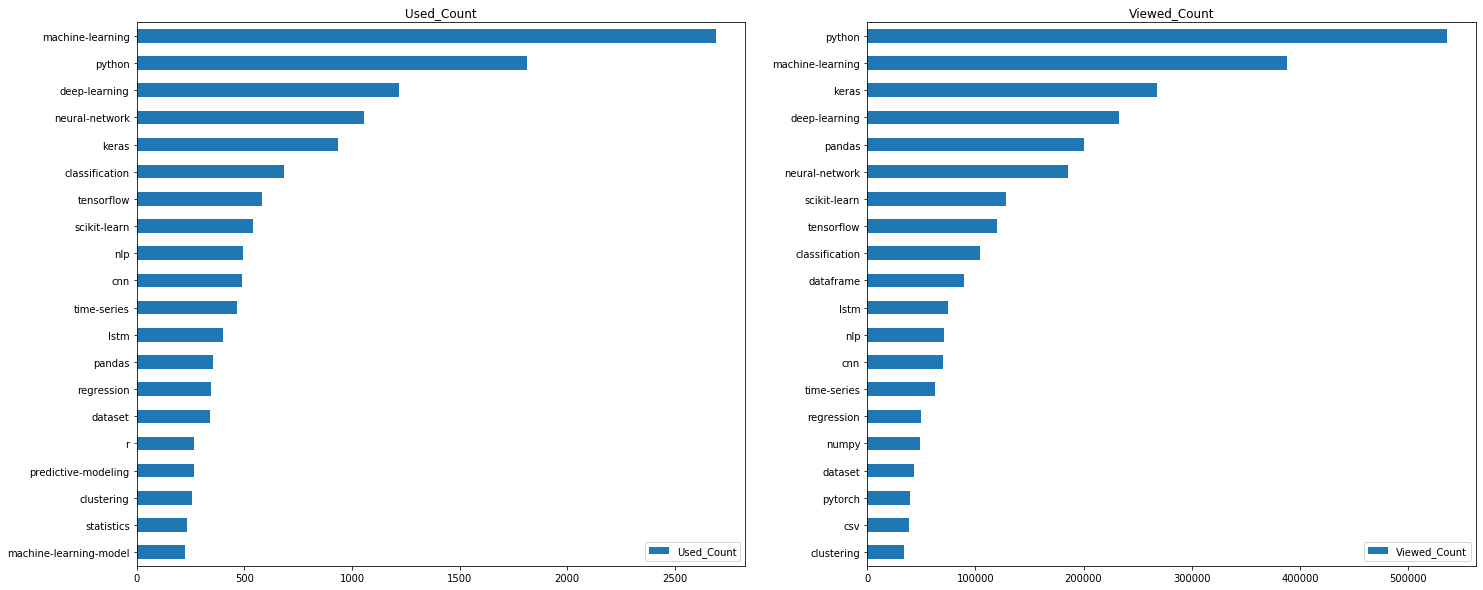

In [14]:
# visualizing the results most_used and most_viewed tags

# instantiating a figure object and creating axes of two plots of (1,2)
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))
most_used.plot(kind='barh', ax=axes[0], subplots=True)
most_viewed.plot(kind='barh', ax=axes[1], subplots=True)

Looking at the above results, it is obvious that most top tags are present in both dataframes.

In [15]:
# merging both most_used and most_viewed dataframes to identify tags
# that are in most_used but not in most_viewed or viceversa

in_used = pd.merge(most_used, most_viewed, how='left', left_index=True, right_index=True)
in_viewed = pd.merge(most_used, most_viewed, how='right', left_index=True, right_index=True)
print(in_used.head())
print('\n')
print(in_viewed.head())

                        Used_Count  Viewed_Count
machine-learning-model         224           NaN
statistics                     234           NaN
clustering                     257       33824.0
predictive-modeling            265           NaN
r                              268           NaN


            Used_Count  Viewed_Count
clustering       257.0         33824
csv                NaN         38453
pytorch            NaN         39887
dataset          340.0         43133
numpy              NaN         48556


The tags present in `most_used` and not present in `most_viewed` are:

- machine-learning-model
- statistics
- predictive-modeling
- r

And the tags present in `most_viewed` but not in `most_used` are:

- csv
- pytorch
- dataframe

In [16]:
# determining the relations between tags by counting the number of times each pair appear together

# creating a list of tags
tags_list = list(tag_count.index)

# creating dataframe of tags_list to determine pair counts
related_tags = pd.DataFrame(index=tags_list, columns=tags_list)
related_tags.iloc[:4,:4]

,machine-learning,data-mining,regression,linear-regression
machine-learning,NaN,NaN,NaN,NaN
data-mining,NaN,NaN,NaN,NaN
regression,NaN,NaN,NaN,NaN
linear-regression,NaN,NaN,NaN,NaN


In [17]:
# filling 'NaN' values with zeros
related_tags.fillna(0, inplace=True)

# counting the increment of tags pair
for tags in questions['Tags']:
    related_tags.loc[tags, tags] += 1

In [18]:
related_tags.iloc[:4,:4]

,machine-learning,data-mining,regression,linear-regression
machine-learning,2693,95,119,68
data-mining,95,217,3,1
regression,119,3,347,35
linear-regression,68,1,35,175


In [19]:
# above dataframe is quite large and therefore filtering the above results with counts of most_used tags
relations_most_used = related_tags.loc[most_used.index, most_used.index]

relations_most_used

,machine-learning-model,statistics,clustering,predictive-modeling,r,dataset,regression,pandas,lstm,time-series,cnn,nlp,scikit-learn,tensorflow,classification,keras,neural-network,deep-learning,python,machine-learning
machine-learning-model,224,3,3,21,7,12,8,4,5,7,4,4,18,9,21,17,10,19,37,139
statistics,3,234,3,16,16,17,16,3,1,22,1,3,6,0,19,3,11,12,35,89
clustering,3,3,257,0,16,5,2,5,3,20,0,9,24,0,12,0,8,2,45,61
predictive-modeling,21,16,0,265,13,7,28,4,13,31,6,1,12,6,27,11,13,32,35,123
r,7,16,16,13,268,6,10,2,3,22,2,4,1,1,10,10,9,5,24,63
dataset,12,17,5,7,6,340,6,14,7,6,11,11,9,9,28,13,20,32,53,99
regression,8,16,2,28,10,6,347,6,11,24,6,2,37,9,34,31,42,21,59,119
pandas,4,3,5,4,2,14,6,354,7,19,1,3,37,3,3,3,1,1,244,62
lstm,5,1,3,13,3,7,11,7,402,87,24,19,2,43,20,133,69,103,61,71
time-series,7,22,20,31,22,6,24,19,87,466,8,0,12,9,25,51,33,44,105,131


In [20]:
relations_most_used.shape

(20, 20)

In [21]:
# getting rid of the values in diagonal, otherwise the colors in the heatmap will be too skewed.
for i in range(relations_most_used.shape[0]):
    relations_most_used.iloc[i,i] = pd.np.NaN # converting cells (rows, columns) - ((0,0),(1,1) upto (19,19)
                                              # containing huge counts to NaN

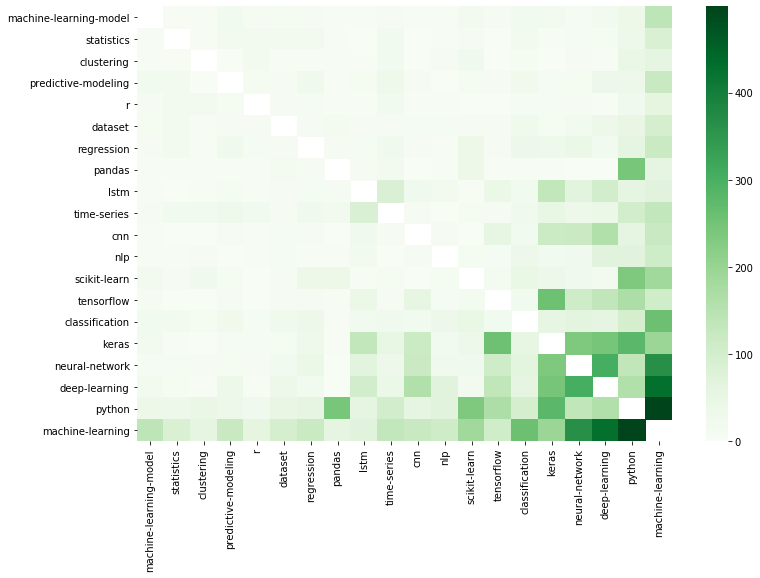

In [22]:
# visualizing above table with heatmap for better understanding
plt.figure(figsize=(12,8))
sns.heatmap(relations_most_used, cmap="Greens", annot=False)

The most used tags also seem to have the strongest relationships, as given by the dark concentration in the bottom right corner. Furthermore, anyone having the domain knowledge (i.e. of Data Science) may determine, by looking at above map, that questions tags related to `deep-learning`;  'lstm', 'cnn', 'scikit-learn', 'tensorflow', 'keras', 'neural-network', 'deep-learning' are the most-asked questions.

Examining if the above analysis results are just a Fad by going through [all_questions.csv](https://github.com/syed0019/Investigating_Data_Science_Stack_Exchange/blob/master/all_questions.csv) file containing all the questions asked on the DSSE (Data Science Stack Exchange).

In [23]:
# reading file into dataframe
all_questions = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])
all_questions.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,<python><keras><tensorflow><cnn><probability>
1,45418,2019-02-12 00:50:39,<neural-network>
2,45422,2019-02-12 04:40:51,<python><ibm-watson><chatbot>
3,45426,2019-02-12 04:51:49,<keras>
4,45427,2019-02-12 05:08:24,<r><predictive-modeling><machine-learning-mode...


In [24]:
# cleaning the Tags column in all_questions dataframe
all_questions['Tags'] = all_questions['Tags'].str.replace('^<|>$','').str.split('><')
all_questions.sample(5)

,Id,CreationDate,Tags
11368,20079,2017-06-30 08:18:43,"[machine-learning, neural-network, backpropaga..."
2093,37955,2018-09-08 05:31:15,"[machine-learning, neural-network, deep-learni..."
16722,11509,2016-04-29 15:43:44,"[machine-learning, classification, neural-netw..."
3025,1174,2014-09-28 12:51:43,"[data-mining, classification, dataset, cluster..."
10010,50813,2019-04-24 02:44:16,"[machine-learning, overfitting]"


In [25]:
# extracting the most_used dataframe
most_used

,Used_Count
machine-learning-model,224
statistics,234
clustering,257
predictive-modeling,265
r,268
dataset,340
regression,347
pandas,354
lstm,402
time-series,466


In [26]:
# making a list of tags related to deep learning questions based on the most_used dataframe above
deep_learning_tags = ['lstm', 'cnn', 'scikit-learn', 'tensorflow',
                      'keras', 'neural-network', 'deep-learning']

#  creating a function that assigns 1 to deep learning questions and 0 otherwise
def deep_learning(tags):
    for tag in tags:
        if tag in deep_learning_tags:
            return 1
    return 0

# appling above function to Tags column of all_questions dataframe to newly created column
all_questions['DeepLearning'] = all_questions['Tags'].apply(deep_learning)

all_questions.head()

,Id,CreationDate,Tags,DeepLearning
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1
1,45418,2019-02-12 00:50:39,[neural-network],1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0
3,45426,2019-02-12 04:51:49,[keras],1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0


In [27]:
# extracting the timeperiod in which questions were asked in the format (yyq - YearQuarter)

# getting rid of the first quarter of 2020 as there is incomplete data pertaining to this quarter
all_questions = all_questions[all_questions['CreationDate'].dt.year < 2020]

# defining a function to fetch quarter(s) in which questions were asked
def fetch_quarter(datetime):
    year = str(datetime.year)
    quarter = str(((datetime.month-1) // 3) + 1)
    return '{0}Q{1}'.format(year, quarter)

# applying above function to datetime object in all_questions dataframe
all_questions['Quarter'] = all_questions['CreationDate'].apply(fetch_quarter)

all_questions.sample(5)

,Id,CreationDate,Tags,DeepLearning,Quarter
9121,28499,2018-03-02 01:55:22,"[python, keras, image-classification, cnn]",1,2018Q1
2611,56510,2019-07-28 08:53:50,"[machine-learning, machine-learning-model, dat...",0,2019Q3
15696,44875,2019-01-31 19:13:36,"[machine-learning, classification, performance]",0,2019Q1
15880,11175,2016-04-12 14:53:45,"[python, programming]",0,2016Q2
11848,20296,2017-07-10 10:26:39,"[machine-learning, deep-learning]",1,2017Q3


In [28]:
# counting the number of deep learning questions;
# counting the total number of questions;
# computing the ratio between two numbers.

# grouping data quarter-wise
quarterly_data = all_questions.groupby('Quarter').agg({'DeepLearning': ['sum', 'size']})

# renaming two columns having aggregated calculations
quarterly_data.columns = ['DeepLearningQuestions', 'TotalQuestions']

# computing the ratio
quarterly_data['DeepLearningRate'] = quarterly_data['DeepLearningQuestions'] / quarterly_data['TotalQuestions']

# resetting index
quarterly_data.reset_index(inplace=True)

# printing the results
quarterly_data.sample(5)

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
8,2016Q2,109,518,0.210425
18,2018Q4,531,1294,0.410355
0,2014Q2,9,157,0.057325
4,2015Q2,28,284,0.098592
1,2014Q3,13,189,0.068783


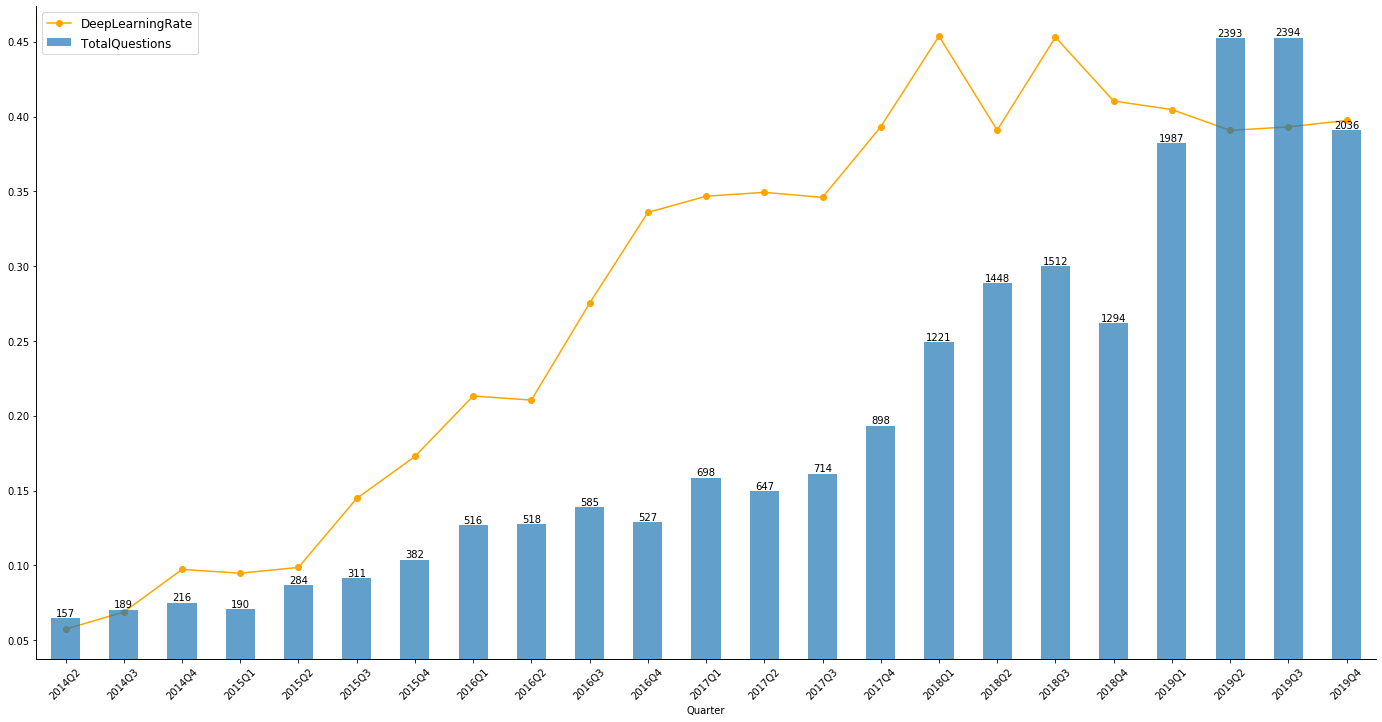

In [29]:
# visualizing the above results to determine pattern

# creating axes one and defining its features
ax1 = quarterly_data.plot(x="Quarter", y="DeepLearningRate", kind="line", linestyle="-",
                          marker="o", color="orange", figsize=(24,12))

# creating axes two and defining its features
ax2 = quarterly_data.plot(x="Quarter", y="TotalQuestions",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

# setting labels of the axes2 (bar)
for idx, t in enumerate(quarterly_data["TotalQuestions"]):
    ax2.text(idx, t, str(t), ha="center", va="bottom")

# setting limit of the horizontal (x-axis)
xlims = ax1.get_xlim()

# removing the individual axes legend
ax1.get_legend().remove()

# joining handles and labels of both axes plots
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})

# setting spines and tick_parameters of both axes in top & right axis as False(off)
for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

Above plot depicts that deep learning questions has remained on high-growth trend since the start of DSSE and there is no evidence to suggest that interest in deep learning is decreasing. Resultantly, it is suggested that an education company should create deep learning content.